In [1]:
import pickle
import pandas as pd

with open('../data/processed_data.pkl', 'rb') as f:
    data = pickle.load(f)

X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']
feature_names = data['feature_names']

with open('../models/best_model.pkl', 'rb') as f:
    best_model = pickle.load(f)

print(type(best_model))
print("Features:", len(feature_names))


<class 'xgboost.sklearn.XGBClassifier'>
Features: 24


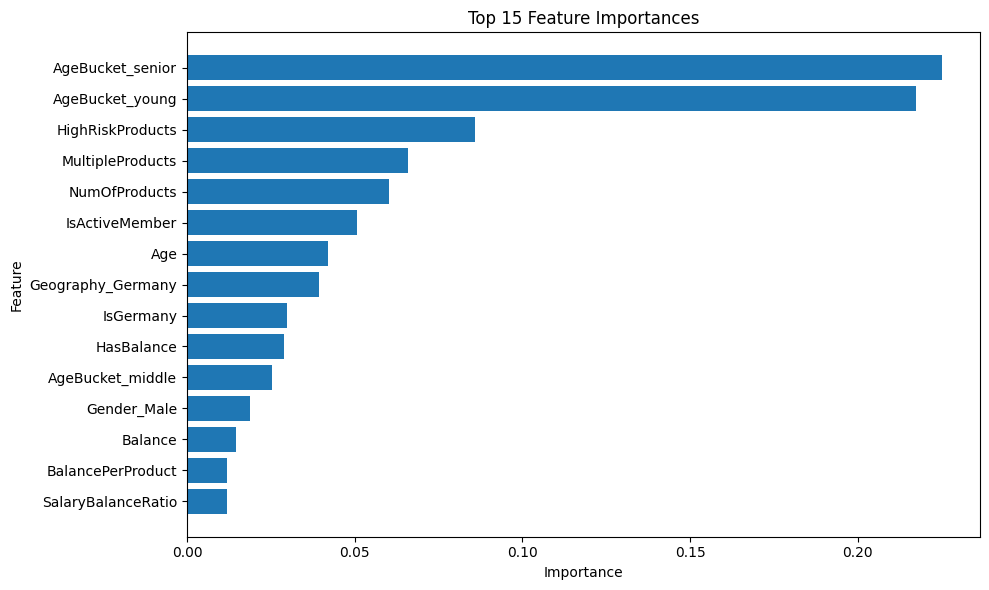

In [2]:
import numpy as np
import matplotlib.pyplot as plt

importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]  # descending
sorted_features = [feature_names[i] for i in indices]

plt.figure(figsize=(10, 6))
plt.barh(sorted_features[:15][::-1], importances[indices][:15][::-1])
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('../plots/07_feature_importance.png', dpi=150)
plt.show()


C:\Users\rohit_tu5\churn\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


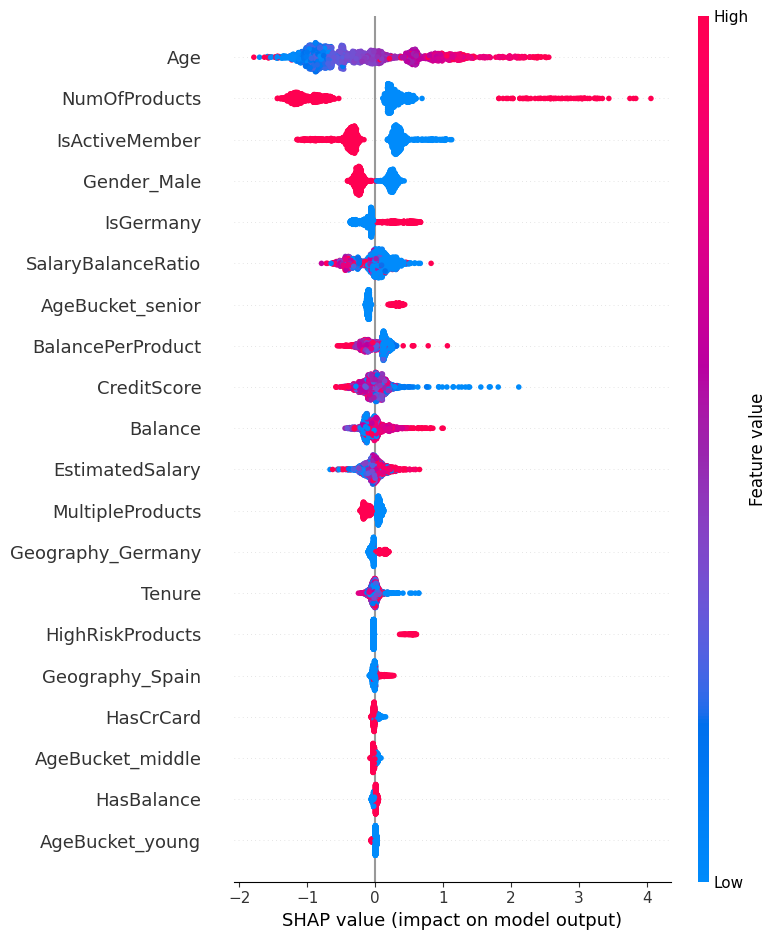

In [3]:
import shap
shap.initjs()

# Use a subset of training data for speed
X_train_sample = X_train.iloc[:2000]

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train_sample)

shap.summary_plot(shap_values, X_train_sample, feature_names=feature_names, show=False)
plt.tight_layout()
plt.savefig('../plots/08_shap_summary.png', dpi=150, bbox_inches='tight')
plt.show()


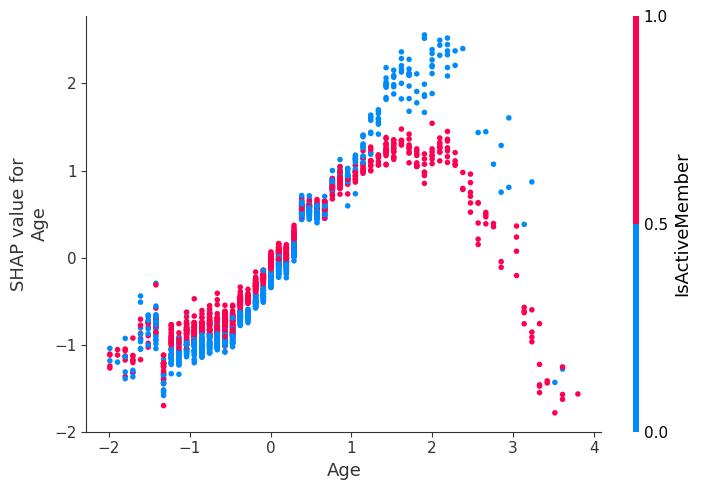

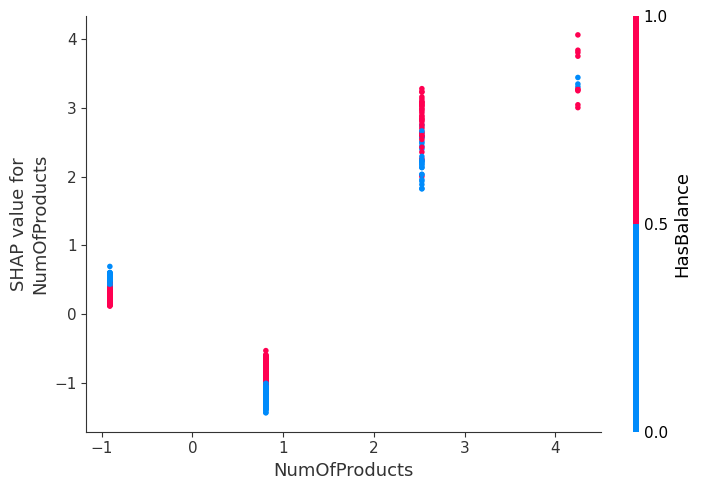

In [4]:
shap.dependence_plot('Age', shap_values, X_train_sample, show=False)
plt.tight_layout()
plt.savefig('../plots/09_shap_age.png', dpi=150)
plt.show()

shap.dependence_plot('NumOfProducts', shap_values, X_train_sample, show=False)
plt.tight_layout()
plt.savefig('../plots/10_shap_products.png', dpi=150)
plt.show()


In [5]:
i = 0  # index
shap.force_plot(explainer.expected_value, shap_values[i, :], X_train_sample.iloc[i, :])


## Model Interpretation – SHAP & Feature Importance Insights

### 1. Top Global Drivers of Churn

From the SHAP summary and feature importance plot, the most influential features are:

1. **AgeBucket_senior / AgeBucket_young / Age**
   - Seniors (older customers) and very young customers show strong impact on churn.
   - SHAP plot for `Age` shows churn risk increases with age up to a point, then drops for the very oldest.

2. **NumOfProducts / MultipleProducts / HighRiskProducts**
   - Customers with **3–4 products** have very high positive SHAP values → strongly associated with churn.
   - Having exactly **2 products** tends to reduce churn risk.

3. **IsActiveMember**
   - Inactive members have higher SHAP values (higher churn risk).
   - Active members are generally protected against churn.

Other important contributors:
- **Geography_Germany / IsGermany**: Being in Germany increases churn risk.
- **HasBalance**: Zero-balance customers behave differently from high-balance customers.
- **BalancePerProduct, SalaryBalanceRatio**: Financial intensity per product also affects churn.

---

### 2. How Key Features Affect Churn

#### Age
- SHAP dependence plot shows:
  - Churn risk increases from young adulthood into middle age.
  - Middle-aged customers (around standardized Age ~1–2) have highest churn contribution.
  - Very young and very old customers contribute less to churn in the model.

#### Number of Products
- SHAP dependence for `NumOfProducts`:
  - 1 product: modest effect.
  - 2 products: SHAP values near/below zero → **lower churn risk**.
  - 3–4 products: large positive SHAP values → **very high churn risk**, confirming EDA.

---

### 3. Combined High‑Risk Profile (Model View)

The model has effectively learned that customers are most likely to churn when they are:

- In **senior/older age buckets**
- Have **3 or more products** (HighRiskProducts = 1)
- Are **inactive members**
- Are from **Germany**
- Often have specific balance and salary-to-balance patterns

This aligns well with our earlier EDA and gives strong, interpretable signals for business actions and targeted retention strategies.
